# Evaluation of experiments
fistly define the UUID of the experiment to use

In [19]:
experimentId="ca1a343f-daa3-4879-9974-993ffe1b8f8b"

-------------------------------------------------------

In [20]:
#external libraries
import numpy as np
import os
import matplotlib.pyplot as plt
import matplotlib.colors as clt
import plotly
import plotly.subplots as sb
import plotly.express as px
import plotly.graph_objects as go
import dotenv
import pandas as pd
import scipy.fft as fft
import scipy.signal as sg
import scipy.io as sio
import pickle as pkl
import xgboost as xgb
import time

#project library
from spinco import *

#environment variables
dotenv.load_dotenv('lab.env')

#project variables
datapath=os.environ['DATAPATH']
cognipath=datapath+"\\COGNITION"
dreamspath=datapath+"\\DREAMS"
masspath=datapath+"\\MASS"


## load mass

In [21]:
samplerate=200  #Should rethink this

In [22]:
annotations, signalsMetadata = loadMASSSpindles(masspath,forceSamplerate=samplerate)

In [23]:
annotations.head()

,type,expert,subjectId,labelerId,startTime,duration,samplerate,stopTime,startInd,stopInd
0,kcomplex,E1,0001,0001,830.596676,0.699174,200,831.295850,166119,166259
1,kcomplex,E1,0001,0001,840.981316,0.492156,200,841.473472,168196,168295
2,kcomplex,E1,0001,0001,970.596678,0.578088,200,971.174766,194119,194235
3,kcomplex,E1,0001,0001,1049.772807,0.695268,200,1050.468075,209955,210094
4,kcomplex,E1,0001,0001,1077.231575,0.648396,200,1077.879971,215446,215576


In [24]:
signalsMetadata.head()

,subjectId,file,channel,duration,samplerate,isOriginalSamplerate,database
0,0001,MASS_0001.pkl,C3-CLE,28956.0,200,False,MASS
1,0002,MASS_0002.pkl,C3-CLE,35016.0,200,False,MASS
2,0003,MASS_0003.pkl,C3-CLE,36760.0,200,False,MASS
3,0004,MASS_0004.pkl,C3-CLE,28004.0,200,False,MASS
4,0005,MASS_0005.pkl,C3-CLE,31244.0,200,False,MASS


## Load experiment results

In [25]:
def loadModel(modelId,experimentId,datapath):
    model=xgb.XGBClassifier()
    model.load_model(datapath+"/experiments/"+experimentId+"/"+modelId+".json")
    return model

In [26]:
def loadExperiment(experimentId,datapath):
    experimentModels=loadPickle(datapath+"/experiments/"+experimentId+"/experimentModels.pkl")
    featureSelection=loadPickle(datapath+"/experiments/"+experimentId+"/featureSelection.pkl")
    return experimentModels, featureSelection

In [27]:
experimentModels, featureSelection = loadExperiment(experimentId,datapath)

In [28]:
experimentModels

,train,val,test,modelId,treeLimit,valF1
0,"[0002, 0003, 0004, 0005, 0007, 0008, 0009, 001...","[0006, 0014]",[0001],a0c50dbf-de0d-4807-89c8-e9fff0e96e60,17,0.621141
1,"[0001, 0003, 0004, 0005, 0006, 0007, 0008, 000...","[0012, 0010]",[0002],50450b1f-2acb-47b6-bbde-85b5b64cf674,11,0.558384


In [11]:
featureSelection

,characteristic,bandName,window
21,hjortActivity,sigma,0.5
66,petrosian,broadband,0.5
22,hjortActivity,theta,0.5
79,relativePower,beta1,0.5
29,hjortComplexity,sigma,0.5


## Annotation criterium

In [12]:
usedAnnotations=annotations[(annotations['type']=='spindle')&(annotations['labelerId']=='0001')]

## Grid search of hyperparameters

In [13]:
from itertools import product

allClose=[0.1,0.25,0.4,0.55]
allDuration=[0.1,0.3,0.4,0.5]
allConfidence=[0.0,0.25,0.5,0.75]

In [14]:
closes=list()
durations=list()
confidences=list()
for hyper in product(allClose, allDuration,allConfidence):
    closes.append(hyper[0])
    durations.append(hyper[1])
    confidences.append(hyper[2])

hyperparams=pd.DataFrame({
    "close":closes,
    "duration":durations,
    "confidence":confidences
})

hyperparams


,close,duration,confidence
0,0.10,0.1,0.00
1,0.10,0.1,0.25
2,0.10,0.1,0.50
3,0.10,0.1,0.75
4,0.10,0.3,0.00
...,...,...,...
59,0.55,0.4,0.75
60,0.55,0.5,0.00
61,0.55,0.5,0.25
62,0.55,0.5,0.50


## Evaluate each row for each hyperparameter selection

In [15]:
#Set by_event IoU threshold
masterIoU=0.3

#Be conservative, keep the minimum tree limit
masterTreeLimit=np.min(experimentModels.treeLimit)
masterTreeLimit


11

In [16]:
modelMetrics=pd.DataFrame()

for ind_hyper, hyper in hyperparams.iterrows():
    print("***********************")
    print(ind_hyper)
    for ind_CV, row in experimentModels.iterrows():
        #load testing
        testFeatures=loadFeatureMatrix(row.test,featureSelection,signalsMetadata,samplerate,datapath)
        testLabels=loadLabelsVector(row.test,usedAnnotations,signalsMetadata,samplerate)
        #predict labels
        model=loadModel(row.modelId,experimentId,datapath)
        predictedLabels=model.predict(testFeatures,ntree_limit=masterTreeLimit)
        #process labels
        processedLabels=labelingProcess(predictedLabels,hyper.close,hyper.duration,samplerate)
        #get confidence score and filter
        predictedAnnotations=labelVectorToAnnotations(predictedLabels,samplerate)
        processedAnnotations=labelVectorToAnnotations(processedLabels,samplerate)
        processedAnnotations['confidence']=processedAnnotations.apply(
            lambda row: getConfidence(row,predictedAnnotations)
            ,axis=1)
        finalAnnotations=processedAnnotations[processedAnnotations.confidence>hyper.confidence].copy().reset_index(drop=True)
        #by event calculations
        gtAnnotations=labelVectorToAnnotations(testLabels,samplerate)   #<- or just filter the annotations
        tp,fp,fn = byEventEvaluation(gtAnnotations,finalAnnotations,thres_IoU=masterIoU)
        #consistency check
        check=tp*2+fp+fn==len(gtAnnotations)+len(finalAnnotations)
        #calculate metrics
        finalLabels=excerptAnnotationsToLabels(finalAnnotations,len(testLabels))
        vector_F1_raw=F1(testLabels,predictedLabels)
        vector_F1=F1(testLabels,finalLabels)
        event_F1=2*tp/(2*tp+fp+fn)
        event_Precision=tp/(tp+fp)
        event_Recall=tp/(tp+fn)
        event_TS=tp/(tp+fn+fp)
        
        #append to the dataframe
        newRow=pd.Series({
            "ind_hyper":ind_hyper,
            "ind_model":ind_CV,
            "thres_IoU":masterIoU,
            "treeLimit":masterTreeLimit,
            "check":check,
            "final_count":len(finalAnnotations),
            "gt_count":len(gtAnnotations),
            "tp":tp,
            "fp":fp,
            "fn":fn,
            "vector_F1_raw":vector_F1_raw,
            "vector_F1":vector_F1,
            "event_F1":event_F1,
            "event_Precision":event_Precision,
            "event_Recall":event_Recall,
            "event_TS":event_TS})
        modelMetrics=pd.concat([modelMetrics,newRow.to_frame().T],ignore_index=True)
        
        if not check:   #<---- check must always be passed, if not correct the byEventEvaluation function
            print("check failed on hyper "+str(ind_hyper)+" and CV "+str(ind_CV))
            break


***********************
0


c:\Users\Gurdiel\Code\Testing\venv\lib\site-packages\xgboost\core.py:91: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(
c:\Users\Gurdiel\Code\Testing\venv\lib\site-packages\xgboost\core.py:91: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(


***********************
1


c:\Users\Gurdiel\Code\Testing\venv\lib\site-packages\xgboost\core.py:91: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(
c:\Users\Gurdiel\Code\Testing\venv\lib\site-packages\xgboost\core.py:91: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(


***********************
2


c:\Users\Gurdiel\Code\Testing\venv\lib\site-packages\xgboost\core.py:91: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(
c:\Users\Gurdiel\Code\Testing\venv\lib\site-packages\xgboost\core.py:91: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(


***********************
3


c:\Users\Gurdiel\Code\Testing\venv\lib\site-packages\xgboost\core.py:91: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(
c:\Users\Gurdiel\Code\Testing\venv\lib\site-packages\xgboost\core.py:91: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(


***********************
4


c:\Users\Gurdiel\Code\Testing\venv\lib\site-packages\xgboost\core.py:91: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(
c:\Users\Gurdiel\Code\Testing\venv\lib\site-packages\xgboost\core.py:91: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(


***********************
5


c:\Users\Gurdiel\Code\Testing\venv\lib\site-packages\xgboost\core.py:91: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(
c:\Users\Gurdiel\Code\Testing\venv\lib\site-packages\xgboost\core.py:91: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(


***********************
6


c:\Users\Gurdiel\Code\Testing\venv\lib\site-packages\xgboost\core.py:91: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(
c:\Users\Gurdiel\Code\Testing\venv\lib\site-packages\xgboost\core.py:91: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(


***********************
7


c:\Users\Gurdiel\Code\Testing\venv\lib\site-packages\xgboost\core.py:91: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(
c:\Users\Gurdiel\Code\Testing\venv\lib\site-packages\xgboost\core.py:91: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(


***********************
8


c:\Users\Gurdiel\Code\Testing\venv\lib\site-packages\xgboost\core.py:91: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(
c:\Users\Gurdiel\Code\Testing\venv\lib\site-packages\xgboost\core.py:91: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(


***********************
9


c:\Users\Gurdiel\Code\Testing\venv\lib\site-packages\xgboost\core.py:91: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(
c:\Users\Gurdiel\Code\Testing\venv\lib\site-packages\xgboost\core.py:91: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(


***********************
10


c:\Users\Gurdiel\Code\Testing\venv\lib\site-packages\xgboost\core.py:91: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(
c:\Users\Gurdiel\Code\Testing\venv\lib\site-packages\xgboost\core.py:91: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(


***********************
11


c:\Users\Gurdiel\Code\Testing\venv\lib\site-packages\xgboost\core.py:91: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(
c:\Users\Gurdiel\Code\Testing\venv\lib\site-packages\xgboost\core.py:91: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(


***********************
12


c:\Users\Gurdiel\Code\Testing\venv\lib\site-packages\xgboost\core.py:91: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(
c:\Users\Gurdiel\Code\Testing\venv\lib\site-packages\xgboost\core.py:91: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(


***********************
13


c:\Users\Gurdiel\Code\Testing\venv\lib\site-packages\xgboost\core.py:91: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(
c:\Users\Gurdiel\Code\Testing\venv\lib\site-packages\xgboost\core.py:91: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(


***********************
14


c:\Users\Gurdiel\Code\Testing\venv\lib\site-packages\xgboost\core.py:91: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(
c:\Users\Gurdiel\Code\Testing\venv\lib\site-packages\xgboost\core.py:91: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(


***********************
15


c:\Users\Gurdiel\Code\Testing\venv\lib\site-packages\xgboost\core.py:91: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(
c:\Users\Gurdiel\Code\Testing\venv\lib\site-packages\xgboost\core.py:91: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(


***********************
16


c:\Users\Gurdiel\Code\Testing\venv\lib\site-packages\xgboost\core.py:91: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(
c:\Users\Gurdiel\Code\Testing\venv\lib\site-packages\xgboost\core.py:91: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(


***********************
17


c:\Users\Gurdiel\Code\Testing\venv\lib\site-packages\xgboost\core.py:91: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(
c:\Users\Gurdiel\Code\Testing\venv\lib\site-packages\xgboost\core.py:91: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(


***********************
18


c:\Users\Gurdiel\Code\Testing\venv\lib\site-packages\xgboost\core.py:91: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(
c:\Users\Gurdiel\Code\Testing\venv\lib\site-packages\xgboost\core.py:91: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(


***********************
19


c:\Users\Gurdiel\Code\Testing\venv\lib\site-packages\xgboost\core.py:91: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(
c:\Users\Gurdiel\Code\Testing\venv\lib\site-packages\xgboost\core.py:91: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(


***********************
20


c:\Users\Gurdiel\Code\Testing\venv\lib\site-packages\xgboost\core.py:91: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(
c:\Users\Gurdiel\Code\Testing\venv\lib\site-packages\xgboost\core.py:91: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(


***********************
21


c:\Users\Gurdiel\Code\Testing\venv\lib\site-packages\xgboost\core.py:91: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(
c:\Users\Gurdiel\Code\Testing\venv\lib\site-packages\xgboost\core.py:91: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(


***********************
22


c:\Users\Gurdiel\Code\Testing\venv\lib\site-packages\xgboost\core.py:91: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(
c:\Users\Gurdiel\Code\Testing\venv\lib\site-packages\xgboost\core.py:91: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(


***********************
23


c:\Users\Gurdiel\Code\Testing\venv\lib\site-packages\xgboost\core.py:91: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(
c:\Users\Gurdiel\Code\Testing\venv\lib\site-packages\xgboost\core.py:91: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(


***********************
24


c:\Users\Gurdiel\Code\Testing\venv\lib\site-packages\xgboost\core.py:91: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(
c:\Users\Gurdiel\Code\Testing\venv\lib\site-packages\xgboost\core.py:91: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(


***********************
25


c:\Users\Gurdiel\Code\Testing\venv\lib\site-packages\xgboost\core.py:91: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(
c:\Users\Gurdiel\Code\Testing\venv\lib\site-packages\xgboost\core.py:91: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(


***********************
26


c:\Users\Gurdiel\Code\Testing\venv\lib\site-packages\xgboost\core.py:91: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(
c:\Users\Gurdiel\Code\Testing\venv\lib\site-packages\xgboost\core.py:91: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(


***********************
27


c:\Users\Gurdiel\Code\Testing\venv\lib\site-packages\xgboost\core.py:91: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(
c:\Users\Gurdiel\Code\Testing\venv\lib\site-packages\xgboost\core.py:91: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(


***********************
28


c:\Users\Gurdiel\Code\Testing\venv\lib\site-packages\xgboost\core.py:91: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(
c:\Users\Gurdiel\Code\Testing\venv\lib\site-packages\xgboost\core.py:91: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(


***********************
29


c:\Users\Gurdiel\Code\Testing\venv\lib\site-packages\xgboost\core.py:91: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(
c:\Users\Gurdiel\Code\Testing\venv\lib\site-packages\xgboost\core.py:91: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(


***********************
30


c:\Users\Gurdiel\Code\Testing\venv\lib\site-packages\xgboost\core.py:91: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(
c:\Users\Gurdiel\Code\Testing\venv\lib\site-packages\xgboost\core.py:91: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(


***********************
31


c:\Users\Gurdiel\Code\Testing\venv\lib\site-packages\xgboost\core.py:91: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(
c:\Users\Gurdiel\Code\Testing\venv\lib\site-packages\xgboost\core.py:91: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(


***********************
32


c:\Users\Gurdiel\Code\Testing\venv\lib\site-packages\xgboost\core.py:91: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(
c:\Users\Gurdiel\Code\Testing\venv\lib\site-packages\xgboost\core.py:91: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(


***********************
33


c:\Users\Gurdiel\Code\Testing\venv\lib\site-packages\xgboost\core.py:91: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(
c:\Users\Gurdiel\Code\Testing\venv\lib\site-packages\xgboost\core.py:91: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(


***********************
34


c:\Users\Gurdiel\Code\Testing\venv\lib\site-packages\xgboost\core.py:91: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(
c:\Users\Gurdiel\Code\Testing\venv\lib\site-packages\xgboost\core.py:91: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(


***********************
35


c:\Users\Gurdiel\Code\Testing\venv\lib\site-packages\xgboost\core.py:91: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(
c:\Users\Gurdiel\Code\Testing\venv\lib\site-packages\xgboost\core.py:91: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(


***********************
36


c:\Users\Gurdiel\Code\Testing\venv\lib\site-packages\xgboost\core.py:91: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(
c:\Users\Gurdiel\Code\Testing\venv\lib\site-packages\xgboost\core.py:91: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(


***********************
37


c:\Users\Gurdiel\Code\Testing\venv\lib\site-packages\xgboost\core.py:91: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(
c:\Users\Gurdiel\Code\Testing\venv\lib\site-packages\xgboost\core.py:91: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(


***********************
38


c:\Users\Gurdiel\Code\Testing\venv\lib\site-packages\xgboost\core.py:91: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(
c:\Users\Gurdiel\Code\Testing\venv\lib\site-packages\xgboost\core.py:91: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(


***********************
39


c:\Users\Gurdiel\Code\Testing\venv\lib\site-packages\xgboost\core.py:91: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(
c:\Users\Gurdiel\Code\Testing\venv\lib\site-packages\xgboost\core.py:91: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(


***********************
40


c:\Users\Gurdiel\Code\Testing\venv\lib\site-packages\xgboost\core.py:91: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(
c:\Users\Gurdiel\Code\Testing\venv\lib\site-packages\xgboost\core.py:91: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(


***********************
41


c:\Users\Gurdiel\Code\Testing\venv\lib\site-packages\xgboost\core.py:91: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(
c:\Users\Gurdiel\Code\Testing\venv\lib\site-packages\xgboost\core.py:91: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(


***********************
42


c:\Users\Gurdiel\Code\Testing\venv\lib\site-packages\xgboost\core.py:91: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(
c:\Users\Gurdiel\Code\Testing\venv\lib\site-packages\xgboost\core.py:91: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(


***********************
43


c:\Users\Gurdiel\Code\Testing\venv\lib\site-packages\xgboost\core.py:91: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(
c:\Users\Gurdiel\Code\Testing\venv\lib\site-packages\xgboost\core.py:91: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(


***********************
44


c:\Users\Gurdiel\Code\Testing\venv\lib\site-packages\xgboost\core.py:91: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(
c:\Users\Gurdiel\Code\Testing\venv\lib\site-packages\xgboost\core.py:91: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(


***********************
45


c:\Users\Gurdiel\Code\Testing\venv\lib\site-packages\xgboost\core.py:91: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(
c:\Users\Gurdiel\Code\Testing\venv\lib\site-packages\xgboost\core.py:91: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(


***********************
46


c:\Users\Gurdiel\Code\Testing\venv\lib\site-packages\xgboost\core.py:91: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(
c:\Users\Gurdiel\Code\Testing\venv\lib\site-packages\xgboost\core.py:91: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(


***********************
47


c:\Users\Gurdiel\Code\Testing\venv\lib\site-packages\xgboost\core.py:91: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(
c:\Users\Gurdiel\Code\Testing\venv\lib\site-packages\xgboost\core.py:91: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(


***********************
48


c:\Users\Gurdiel\Code\Testing\venv\lib\site-packages\xgboost\core.py:91: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(
c:\Users\Gurdiel\Code\Testing\venv\lib\site-packages\xgboost\core.py:91: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(


***********************
49


c:\Users\Gurdiel\Code\Testing\venv\lib\site-packages\xgboost\core.py:91: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(
c:\Users\Gurdiel\Code\Testing\venv\lib\site-packages\xgboost\core.py:91: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(


***********************
50


c:\Users\Gurdiel\Code\Testing\venv\lib\site-packages\xgboost\core.py:91: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(
c:\Users\Gurdiel\Code\Testing\venv\lib\site-packages\xgboost\core.py:91: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(


***********************
51


c:\Users\Gurdiel\Code\Testing\venv\lib\site-packages\xgboost\core.py:91: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(
c:\Users\Gurdiel\Code\Testing\venv\lib\site-packages\xgboost\core.py:91: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(


***********************
52


c:\Users\Gurdiel\Code\Testing\venv\lib\site-packages\xgboost\core.py:91: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(
c:\Users\Gurdiel\Code\Testing\venv\lib\site-packages\xgboost\core.py:91: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(


***********************
53


c:\Users\Gurdiel\Code\Testing\venv\lib\site-packages\xgboost\core.py:91: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(
c:\Users\Gurdiel\Code\Testing\venv\lib\site-packages\xgboost\core.py:91: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(


***********************
54


c:\Users\Gurdiel\Code\Testing\venv\lib\site-packages\xgboost\core.py:91: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(
c:\Users\Gurdiel\Code\Testing\venv\lib\site-packages\xgboost\core.py:91: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(


***********************
55


c:\Users\Gurdiel\Code\Testing\venv\lib\site-packages\xgboost\core.py:91: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(
c:\Users\Gurdiel\Code\Testing\venv\lib\site-packages\xgboost\core.py:91: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(


***********************
56


c:\Users\Gurdiel\Code\Testing\venv\lib\site-packages\xgboost\core.py:91: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(
c:\Users\Gurdiel\Code\Testing\venv\lib\site-packages\xgboost\core.py:91: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(


***********************
57


c:\Users\Gurdiel\Code\Testing\venv\lib\site-packages\xgboost\core.py:91: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(
c:\Users\Gurdiel\Code\Testing\venv\lib\site-packages\xgboost\core.py:91: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(


***********************
58


c:\Users\Gurdiel\Code\Testing\venv\lib\site-packages\xgboost\core.py:91: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(
c:\Users\Gurdiel\Code\Testing\venv\lib\site-packages\xgboost\core.py:91: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(


***********************
59


c:\Users\Gurdiel\Code\Testing\venv\lib\site-packages\xgboost\core.py:91: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(
c:\Users\Gurdiel\Code\Testing\venv\lib\site-packages\xgboost\core.py:91: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(


***********************
60


c:\Users\Gurdiel\Code\Testing\venv\lib\site-packages\xgboost\core.py:91: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(
c:\Users\Gurdiel\Code\Testing\venv\lib\site-packages\xgboost\core.py:91: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(


***********************
61


c:\Users\Gurdiel\Code\Testing\venv\lib\site-packages\xgboost\core.py:91: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(
c:\Users\Gurdiel\Code\Testing\venv\lib\site-packages\xgboost\core.py:91: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(


***********************
62


c:\Users\Gurdiel\Code\Testing\venv\lib\site-packages\xgboost\core.py:91: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(
c:\Users\Gurdiel\Code\Testing\venv\lib\site-packages\xgboost\core.py:91: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(


***********************
63


c:\Users\Gurdiel\Code\Testing\venv\lib\site-packages\xgboost\core.py:91: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(
c:\Users\Gurdiel\Code\Testing\venv\lib\site-packages\xgboost\core.py:91: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(


In [77]:
hyper

close         0.55
duration      0.50
confidence    0.75
Name: 63, dtype: float64

In [76]:
newRow

ind_hyper                63
ind_model                 1
thres_IoU               0.3
treeLimit                11
check                  True
final_count            1143
gt_count                511
tp                      486
fp                       25
fn                      657
vector_F1_raw      0.612155
vector_F1           0.53963
event_F1           0.587666
event_Precision    0.951076
event_Recall       0.425197
event_TS           0.416096
dtype: object

(array([  2.,   6.,   5.,  14.,  12.,  16.,  20.,  49., 118., 360.]),
 array([0.02307692, 0.12076923, 0.21846154, 0.31615385, 0.41384615,
        0.51153846, 0.60923077, 0.70692308, 0.80461538, 0.90230769,
        1.        ]),
 <BarContainer object of 10 artists>)

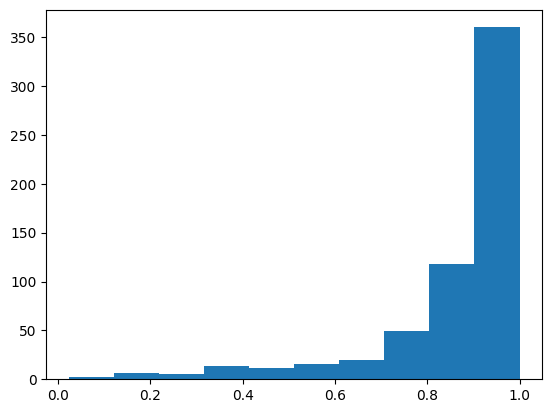

In [75]:
plt.hist(processedAnnotations.confidence)

In [47]:
#should change this
dumpPickle("modelMetrics_"+experimentId,[modelMetrics,hyperparams])

## Represent or decide somehow
this should be in another script

In [50]:
modelMetrics.head()

,ind_hyper,ind_model,thres_IoU,treeLimit,check,final_count,gt_count,tp,fp,fn,vector_F1_raw,vector_F1,event_F1,event_Precision,event_Recall,event_TS
0,0,0,0.3,11,True,409,1044,304,105,740,0.283967,0.338391,0.418445,0.743276,0.291188,0.264578
1,0,1,0.3,11,True,1156,1143,805,351,338,0.612155,0.659983,0.700304,0.696367,0.704287,0.538822
2,1,0,0.3,11,True,387,1044,298,89,746,0.283967,0.331482,0.416492,0.770026,0.285441,0.263019
3,1,1,0.3,11,True,1125,1143,802,323,341,0.612155,0.659123,0.707231,0.712889,0.701662,0.547067
4,2,0,0.3,11,True,326,1044,278,48,766,0.283967,0.311015,0.405839,0.852761,0.266284,0.254579


In [57]:
hyperparams["ind_hyper"]=hyperparams.index

In [58]:
hyperparams.head(5)

,close,duration,confidence,ind_hyper
0,0.1,0.1,0.00,0
1,0.1,0.1,0.25,1
2,0.1,0.1,0.50,2
3,0.1,0.1,0.75,3
4,0.1,0.3,0.00,4


In [59]:
mergedResults=pd.merge(modelMetrics,hyperparams,on="ind_hyper")
mergedResults

,ind_hyper,ind_model,thres_IoU,treeLimit,check,final_count,gt_count,tp,fp,fn,vector_F1_raw,vector_F1,event_F1,event_Precision,event_Recall,event_TS,close,duration,confidence
0,0,0,0.3,11,True,409,1044,304,105,740,0.283967,0.338391,0.418445,0.743276,0.291188,0.264578,0.10,0.1,0.00
1,0,1,0.3,11,True,1156,1143,805,351,338,0.612155,0.659983,0.700304,0.696367,0.704287,0.538822,0.10,0.1,0.00
2,1,0,0.3,11,True,387,1044,298,89,746,0.283967,0.331482,0.416492,0.770026,0.285441,0.263019,0.10,0.1,0.25
3,1,1,0.3,11,True,1125,1143,802,323,341,0.612155,0.659123,0.707231,0.712889,0.701662,0.547067,0.10,0.1,0.25
4,2,0,0.3,11,True,326,1044,278,48,766,0.283967,0.311015,0.405839,0.852761,0.266284,0.254579,0.10,0.1,0.50
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
123,61,1,0.3,11,True,593,1143,552,41,591,0.612155,0.58326,0.635945,0.93086,0.48294,0.466216,0.55,0.5,0.25
124,62,0,0.3,11,True,158,1044,154,4,890,0.283967,0.218689,0.25624,0.974684,0.14751,0.146947,0.55,0.5,0.50
125,62,1,0.3,11,True,563,1143,527,36,616,0.612155,0.567184,0.617819,0.936057,0.461067,0.446989,0.55,0.5,0.50
126,63,0,0.3,11,True,146,1044,142,4,902,0.283967,0.204966,0.238655,0.972603,0.136015,0.135496,0.55,0.5,0.75


In [63]:
px.scatter(mergedResults,x="confidence",y="event_F1",facet_col="duration",facet_row="close",color="ind_model")

In [71]:
for i in range(2):
    thisMerged=mergedResults[mergedResults.ind_model==i].reset_index(drop=True)
    thisEventF1=thisMerged.event_F1
    aux=np.argmax(thisEventF1)
    print(i)
    print(thisMerged.iloc[aux])


0
ind_hyper                32
ind_model                 0
thres_IoU               0.3
treeLimit                11
check                  True
final_count             410
gt_count               1044
tp                      318
fp                       92
fn                      726
vector_F1_raw      0.283967
vector_F1           0.34532
event_F1           0.437414
event_Precision     0.77561
event_Recall       0.304598
event_TS            0.27993
close                   0.4
duration                0.1
confidence              0.0
Name: 32, dtype: object
1
ind_hyper                52
ind_model                 1
thres_IoU               0.3
treeLimit                11
check                  True
final_count             919
gt_count               1143
tp                      784
fp                      135
fn                      359
vector_F1_raw      0.612155
vector_F1          0.658497
event_F1           0.760427
event_Precision    0.853101
event_Recall       0.685914
event_TS           0

In [72]:
px.scatter(mergedResults,x="confidence",y="event_Precision",facet_col="duration",facet_row="close",color="ind_model")

In [73]:
px.scatter(mergedResults,x="confidence",y="event_Recall",facet_col="duration",facet_row="close",color="ind_model")

In [30]:
modelMetrics[["ind_hyper","vector_F1","event_F1"]].groupby("ind_hyper").describe(percentiles=[])

vector_F1                       event_F1                      
              count unique       top freq    count unique       top freq
ind_hyper                                                               
0               2.0    2.0  0.338391  1.0      2.0    2.0  0.418445  1.0
1               2.0    2.0  0.331482  1.0      2.0    2.0  0.416492  1.0
2               2.0    2.0  0.311015  1.0      2.0    2.0  0.405839  1.0
3               2.0    2.0  0.262763  1.0      2.0    2.0  0.340591  1.0
4               2.0    2.0  0.303409  1.0      2.0    2.0  0.406602  1.0
...             ...    ...       ...  ...      ...    ...       ...  ...
59              2.0    2.0  0.235951  1.0      2.0    2.0  0.290820  1.0
60              2.0    2.0  0.225262  1.0      2.0    2.0  0.261806  1.0
61              2.0    2.0  0.224221  1.0      2.0    2.0  0.260365  1.0
62              2.0    2.0  0.218689  1.0      2.0    2.0  0.256240  1.0
63              2.0    2.0  0.204966  1.0      2.0    2.0  0.238655  1.0

[64 rows x 8 columns]

In [34]:
modelMetrics[["ind_hyper","event_Precision","event_Recall"]].groupby("ind_hyper").describe(percentiles=[])

event_Precision                       event_Recall                   \
                    count unique       top freq        count unique       top   
ind_hyper                                                                       
0                     2.0    2.0  0.743276  1.0          2.0    2.0  0.291188   
1                     2.0    2.0  0.770026  1.0          2.0    2.0  0.285441   
2                     2.0    2.0  0.852761  1.0          2.0    2.0  0.266284   
3                     2.0    2.0  0.904959  1.0          2.0    2.0  0.209770   
4                     2.0    2.0  0.937716  1.0          2.0    2.0  0.259579   
...                   ...    ...       ...  ...          ...    ...       ...   
59                    2.0    2.0  0.957219  1.0          2.0    2.0  0.171456   
60                    2.0    2.0  0.969325  1.0          2.0    2.0  0.151341   
61                    2.0    2.0  0.969136  1.0          2.0    2.0  0.150383   
62                    2.0    2.0  0.974684  1.0          2.0    2.0  0.147510   
63                    2.0    2.0  0.972603  1.0          2.0    2.0  0.136015   

                
          freq  
ind_hyper       
0          1.0  
1          1.0  
2          1.0  
3          1.0  
4          1.0  
...        ...  
59         1.0  
60         1.0  
61         1.0  
62         1.0  
63         1.0  

[64 rows x 8 columns]

In [33]:
plt.plot(modelMetrics[["ind_hyper","vector_F1","event_F1"]].groupby("ind_hyper").describe(percentiles=[])["vector_F1","mean"])


KeyError: ('vector_F1', 'mean')

In [32]:
plt.plot(modelMetrics[["ind_hyper","vector_F1","event_F1"]].groupby("ind_hyper").describe(percentiles=[])["vector_F1","mean"])
plt.plot(modelMetrics[["ind_hyper","vector_F1","event_F1"]].groupby("ind_hyper").describe(percentiles=[])["event_F1","mean"])
plt.plot(modelMetrics[["ind_hyper","event_Precision","event_Recall"]].groupby("ind_hyper").describe(percentiles=[])["event_Precision","mean"])
plt.plot(modelMetrics[["ind_hyper","event_Precision","event_Recall"]].groupby("ind_hyper").describe(percentiles=[])["event_Recall","mean"])
plt.legend(["vectorF1","F1","precission","recall"])

KeyError: ('vector_F1', 'mean')

In [ ]:
interests=["vector_F1","event_F1","event_Precision","event_Recall"]

graphStats=pd.DataFrame()
for interest in interests:
    aux=modelMetrics[["ind_hyper",interest]].groupby("ind_hyper",as_index=False).mean()
    aux["mean"]=aux[interest]
    aux["metric"]=interest
    temp1=aux[["ind_hyper","mean","metric"]].copy()
    
    aux=modelMetrics[["ind_hyper",interest]].groupby("ind_hyper",as_index=False).std()
    aux["std"]=aux[interest]
    aux["metric"]=interest
    temp2=aux[["ind_hyper","std","metric"]].copy()

    temp=pd.merge(temp1,temp2,on=["ind_hyper","metric"])

    graphStats=pd.concat([graphStats,temp])


: 

: 

In [ ]:
graphStats

,ind_hyper,mean,metric,std
0,0,0.574798,vector_F1,0.096097
1,1,0.574164,vector_F1,0.097325
2,2,0.570047,vector_F1,0.102882
3,3,0.534684,vector_F1,0.107294
0,0,0.606086,event_F1,0.074014
1,1,0.611399,event_F1,0.076258
2,2,0.628485,event_F1,0.082487
3,3,0.614197,event_F1,0.099147
0,0,0.589063,event_Precision,0.104663
1,1,0.600503,event_Precision,0.108918


: 

: 

In [ ]:
px.line(graphStats,x="ind_hyper",y="mean",error_y="std",color="metric")

: 

: 

: 

: 